# Effect of normalising flow on real-world datasets

In [1]:
%run imports.py

All packages loaded successfully.


In [3]:
def autompg_data():

    auto_mpg = fetch_ucirepo(id=9)

    X_df = auto_mpg.data.features.copy()
    y_df = auto_mpg.data.targets.copy()

    X_df['horsepower'] = pd.to_numeric(X_df['horsepower'], errors='coerce')
    
    horsepower_median = X_df['horsepower'].median()
    X_df['horsepower'].fillna(horsepower_median, inplace=True)
    
    if 'car name' in X_df.columns:
      X_df = X_df.drop('car name', axis=1)
    elif 'car-name' in X_df.columns:
      X_df = X_df.drop('car-name', axis=1)

    X = X_df.to_numpy()
    y = y_df.to_numpy().reshape(-1, 1)


    kf = KFold(n_splits=5, shuffle=True, random_state=42)

    folds_data = []
    fold_counter = 0

    for train_index, test_index in kf.split(X):
        fold_counter += 1

        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]

        y_mean, y_std = np.mean(y_train), np.std(y_train)
        y_train_std = (y_train - y_mean) / y_std
        y_test_std = (y_test - y_mean) / y_std

        scaler = StandardScaler()
        X_train_scaled = scaler.fit_transform(X_train)
        X_test_scaled = scaler.transform(X_test)

        folds_data.append((X_train_scaled, X_test_scaled, y_train_std, y_test_std, y_mean, y_std))

    return folds_data

In [4]:
def boston_housing_data():

    filepath = 'BostonHousing.csv'


    if not os.path.exists(filepath):
        raise FileNotFoundError(
            f"Error: The file '{filepath}' was not found in the current directory."
        )
    
    df = pd.read_csv(filepath)
    df = df[df['medv'] < 50.0] # Remove outliers

    X_df = df.iloc[:, :-1]
    y_df = df.iloc[:, -1]


    X = X_df.to_numpy()
    y = y_df.to_numpy().reshape(-1, 1)


    kf = KFold(n_splits=5, shuffle=True, random_state=42)
    
    folds_data = []
    fold_counter = 0

    for train_index, test_index in kf.split(X):
        fold_counter += 1

        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]

        y_mean, y_std = np.mean(y_train), np.std(y_train)
        y_train_std = (y_train - y_mean) / y_std
        y_test_std = (y_test - y_mean) / y_std

        scaler = StandardScaler()
        X_train_scaled = scaler.fit_transform(X_train)
        X_test_scaled = scaler.transform(X_test)

        folds_data.append((X_train_scaled, X_test_scaled, y_train_std, y_test_std, y_mean, y_std))

    return folds_data


In [5]:
def concrete_data():

    concrete = fetch_ucirepo(id=165)

    df = concrete.data.features.copy()
    df = df.select_dtypes(include='number')
    y_target = concrete.data.targets.copy()

    X = df.to_numpy()
    y = y_target.to_numpy()
    y = y.reshape(-1, 1)

    # Create training and testing data split:
    kf = KFold(n_splits=5, shuffle=True, random_state=42)

    folds_data = []
    fold_counter = 0

    for train_index, test_index in kf.split(X):
        fold_counter += 1

        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]

        y_mean, y_std = np.mean(y_train), np.std(y_train)
        y_train_std = (y_train - y_mean) / y_std
        y_test_std = (y_test - y_mean) / y_std

        scaler = StandardScaler()
        X_train_scaled = scaler.fit_transform(X_train)
        X_test_scaled = scaler.transform(X_test)

        folds_data.append((X_train_scaled, X_test_scaled, y_train_std, y_test_std, y_mean, y_std))

    return folds_data

In [6]:
def nf_data(X_train, X_test):

    seed =4
    np.random.seed(seed)
    tf.random.set_seed(seed)

    num_dims = X_train.shape[1]
    input_flows = [None] * num_dims
    X_transformed = np.zeros_like(X_train)

    
    for i in range(num_dims):
    
        # Extract the 1D data for the current dimension
        d = X_train[:, i]
    
        # Initialize the Normalizer. log=False is safer for data centered at 0.
        n_flow = Normalizer(d, log=True)
    
        # Train the flow by minimizing the KL divergence objective
        opt_flow = gpflow.optimizers.Scipy()
        opt_flow.minimize(n_flow.KL_objective, n_flow.trainable_variables)
    
        # Store the trained flow and apply the transformation
        input_flows[i] = n_flow
        transformed_data_1d = n_flow.bijector(d).numpy()
        X_transformed[:, i] = transformed_data_1d

        ks_statistic, p_value = stats.kstest(transformed_data_1d, 'norm')
        print(f"  KS-test: statistic={ks_statistic:.4f}, p-value={p_value:.4f}")
        if p_value > 0.05:
            print("  (p > 0.05: The null hypothesis that the data is normally distributed cannot be rejected)")
        else:
            print("  (p <= 0.05: The null hypothesis is rejected; data may not be normal)")

        # Histogram
        plt.figure(figsize=(10,5))
        ax = sns.histplot(transformed_data_1d, kde=False, bins=50, color='cornflowerblue', stat='density')
        sns.kdeplot(transformed_data_1d,color='darkred',ax=ax)
        plt.title('Histogram of Transformed Data (Housing)',fontsize=28)
        plt.xlabel('Value', fontsize=24)
        plt.ylabel('Frequency', fontsize=24)
        plt.grid('on')
        plt.tight_layout()
        plt.show()

        # Q-Q Plot
        fig, ax = plt.subplots(figsize=(10, 5))
        stats.probplot(transformed_data_1d, dist="norm", plot=ax)
        ax.get_lines()[0].set_markerfacecolor('cornflowerblue')
        ax.get_lines()[0].set_markeredgecolor('cornflowerblue')
        ax.get_lines()[1].set_color('darkred')  
        ax.set_title('Q-Q Plot vs. Standard Normal (Housing)', fontsize=28)
        plt.xlabel('Theoretical Quantiles', fontsize=24)
        plt.ylabel('Sample Quantiles', fontsize=24)
        plt.grid('on')
        plt.tight_layout()
        plt.show()

    
    X_test_transformed = np.zeros_like(X_test)
    
    for i in range(num_dims):
        
        n_flow = input_flows[i]
        X_test_transformed[:, i] = n_flow.bijector(X_test[:, i]).numpy()

    return X_transformed, X_test_transformed

C:\Users\jacks\AppData\Local\Temp\ipykernel_37284\2744111853.py:11: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  X_df['horsepower'].fillna(horsepower_median, inplace=True)


--------------------- FOLD 0 -----------------------
  KS-test: statistic=0.0799, p-value=0.0327
  (p <= 0.05: The null hypothesis is rejected; data may not be normal)


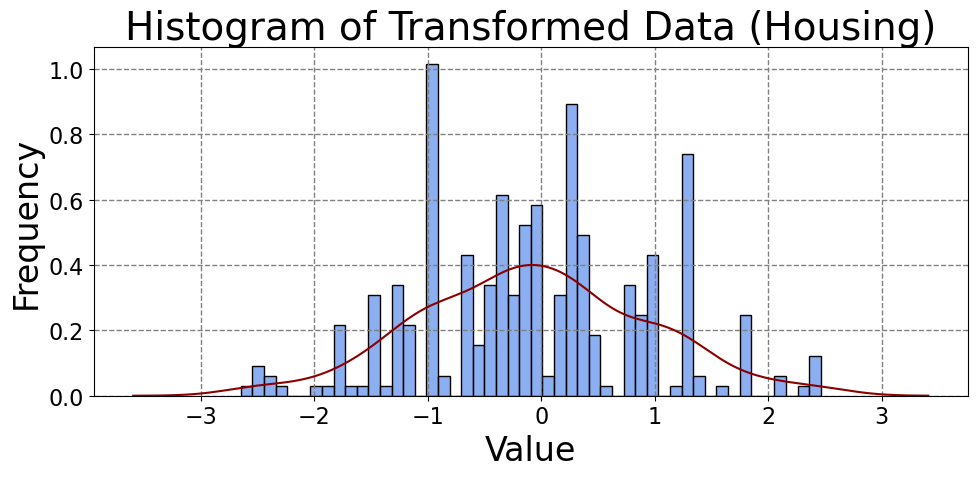

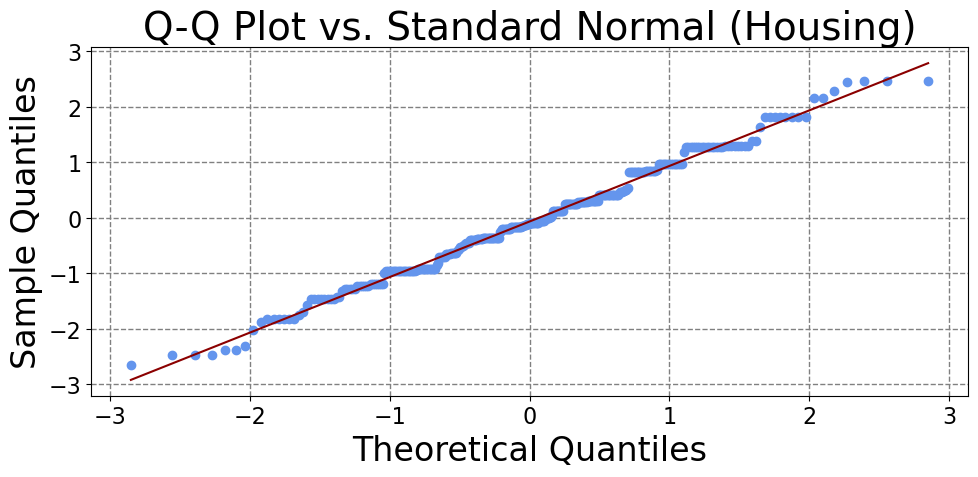

  KS-test: statistic=0.2823, p-value=0.0000
  (p <= 0.05: The null hypothesis is rejected; data may not be normal)


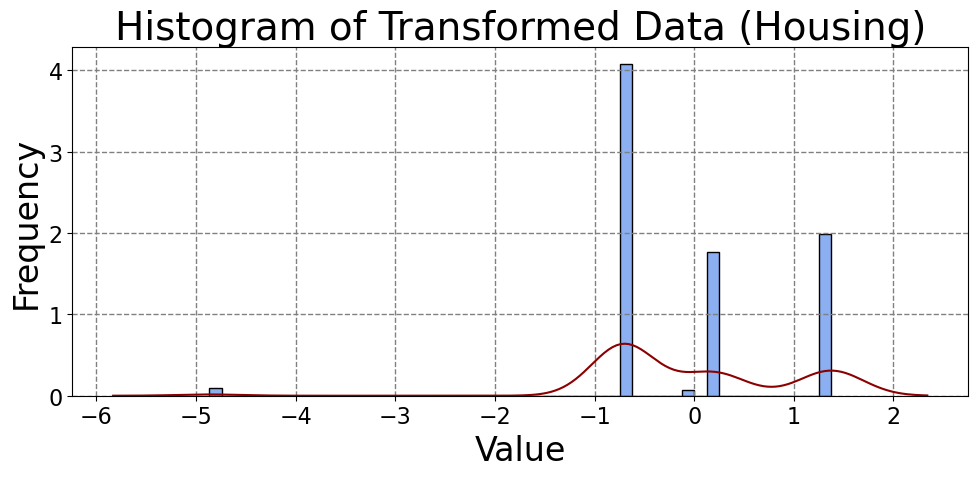

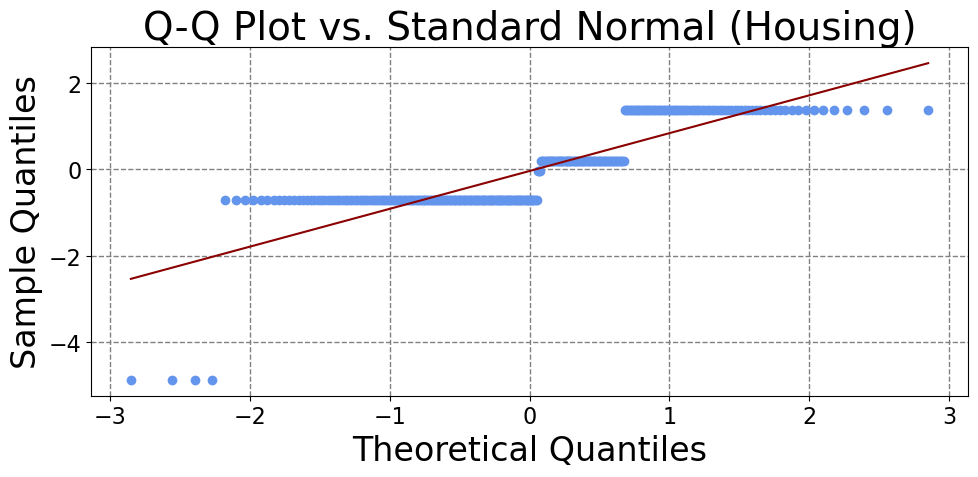

  KS-test: statistic=0.0741, p-value=0.0576
  (p > 0.05: The null hypothesis that the data is normally distributed cannot be rejected)


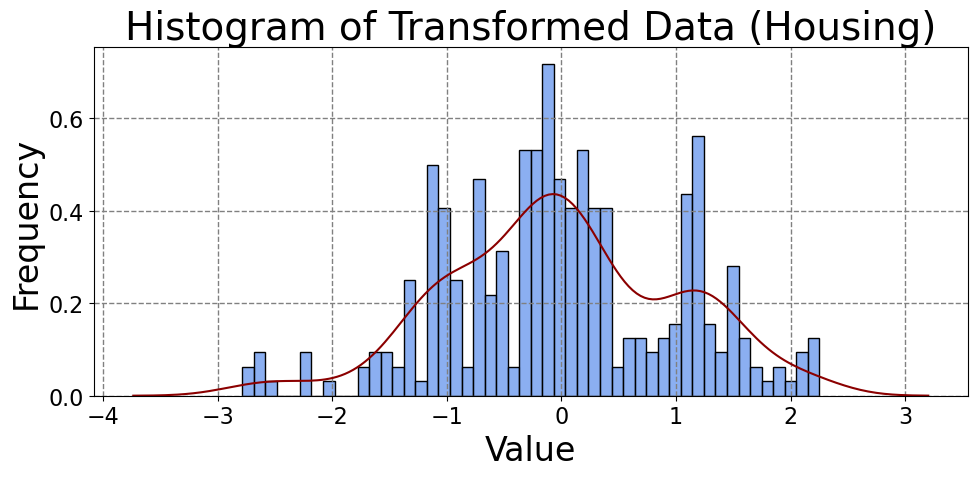

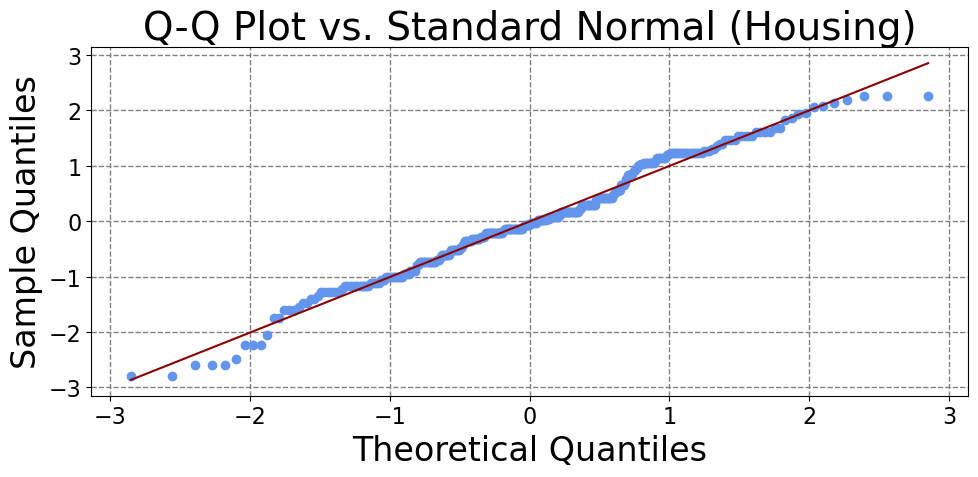

  KS-test: statistic=0.0312, p-value=0.9058
  (p > 0.05: The null hypothesis that the data is normally distributed cannot be rejected)


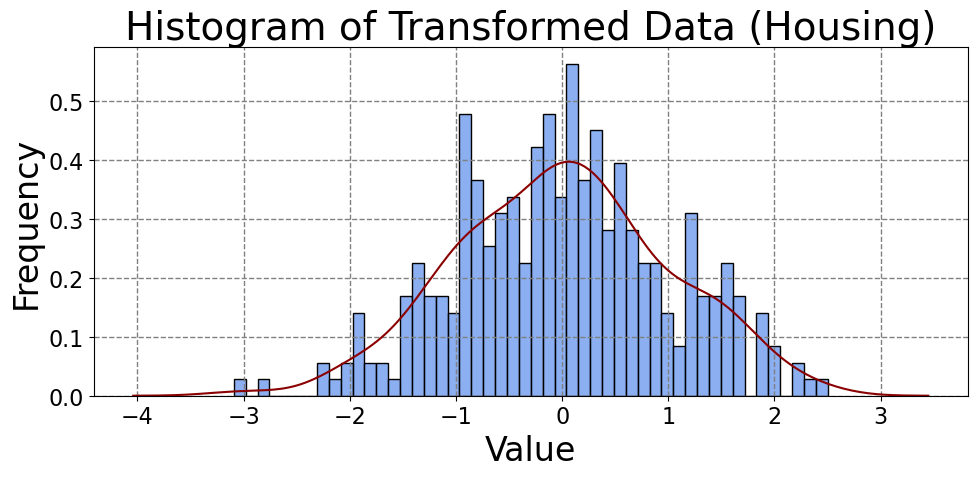

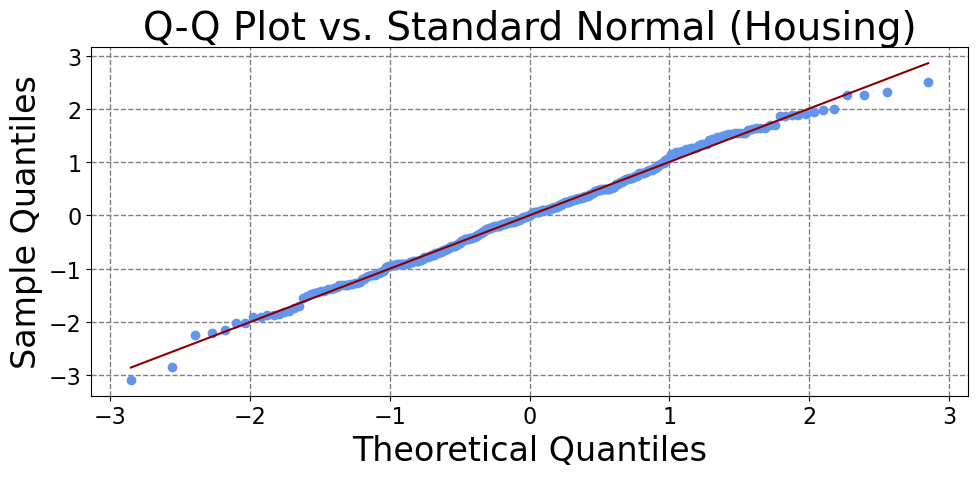

  KS-test: statistic=0.0419, p-value=0.6158
  (p > 0.05: The null hypothesis that the data is normally distributed cannot be rejected)


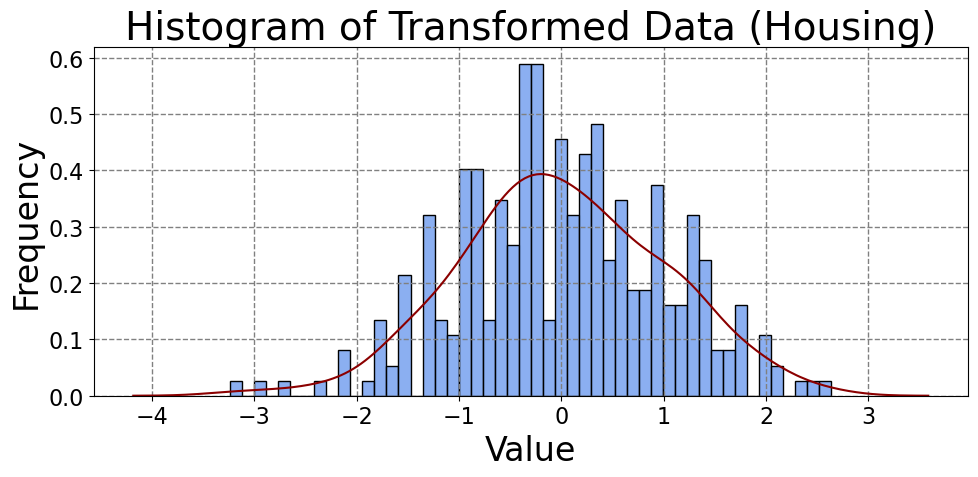

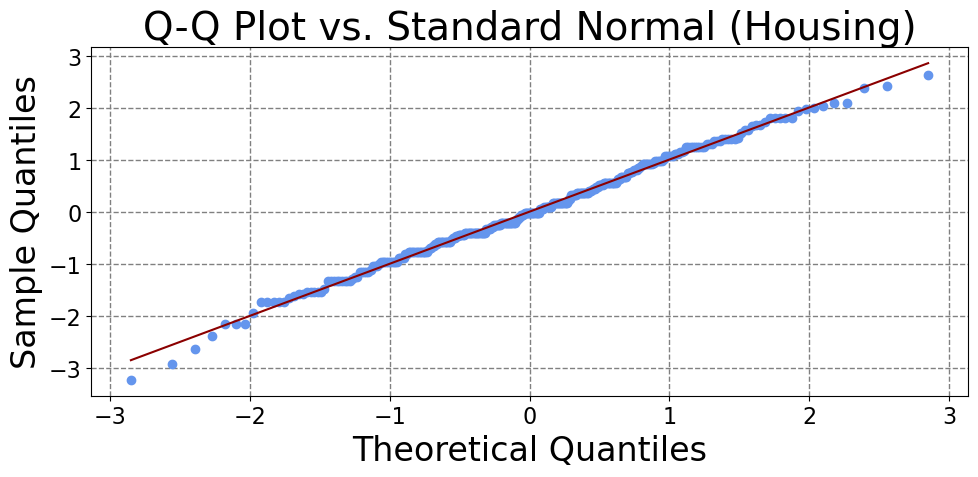

  KS-test: statistic=0.0904, p-value=0.0104
  (p <= 0.05: The null hypothesis is rejected; data may not be normal)


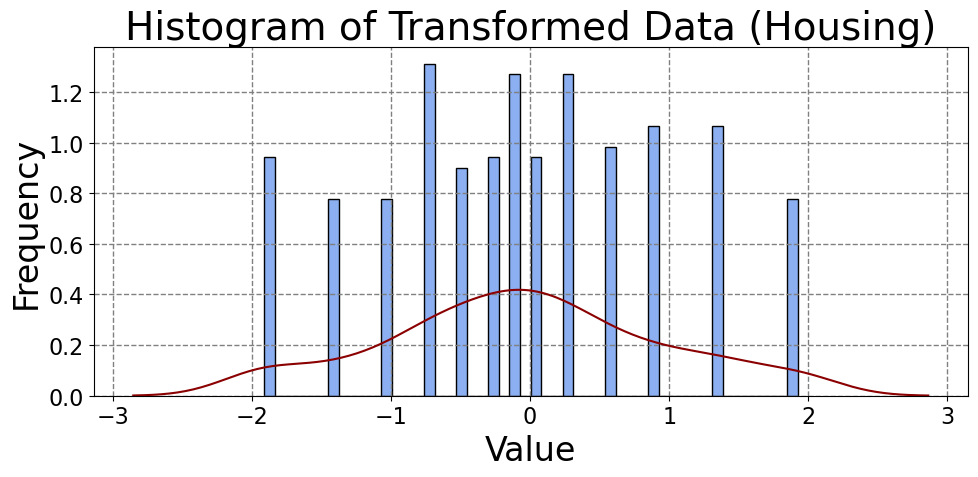

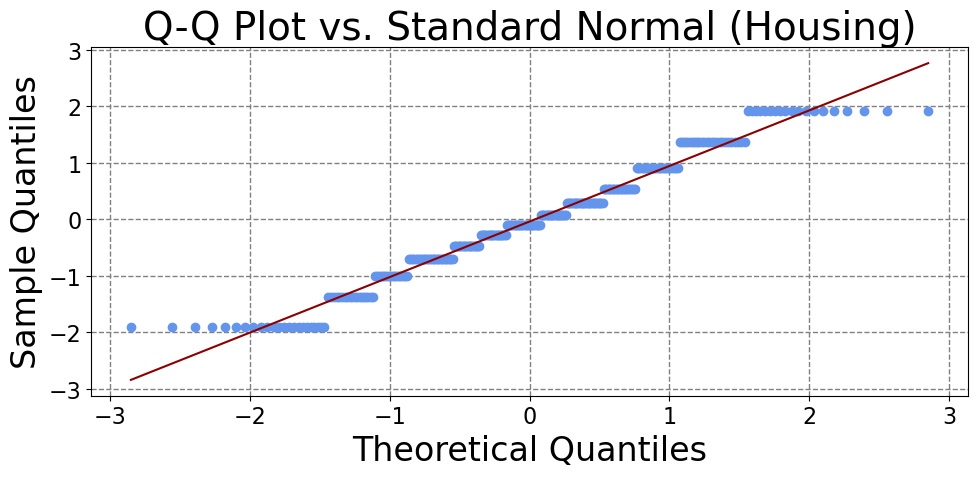

  KS-test: statistic=0.4655, p-value=0.0000
  (p <= 0.05: The null hypothesis is rejected; data may not be normal)


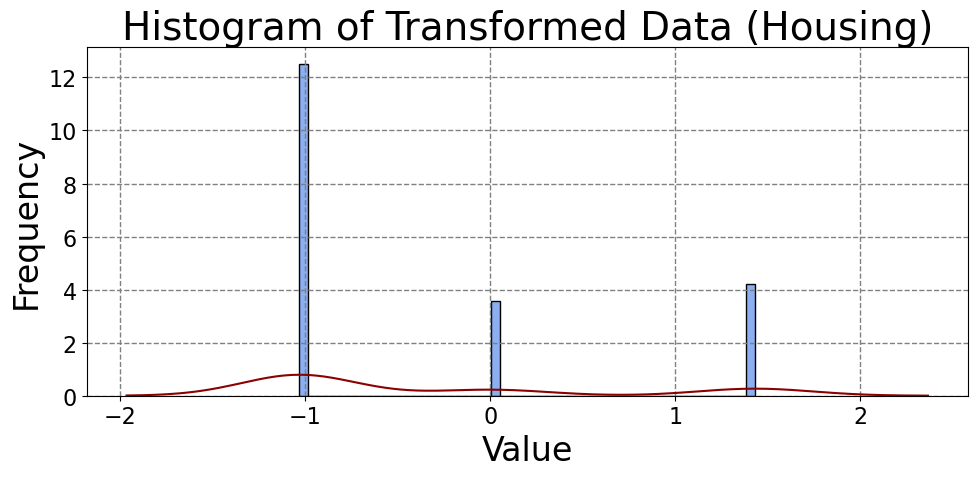

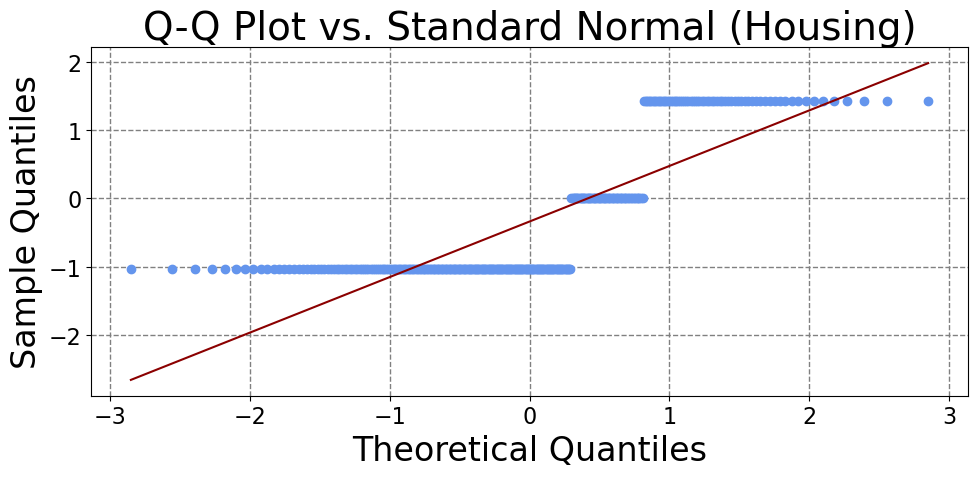

In [7]:
all_folds_data = autompg_data()

for i, fold_data in enumerate(all_folds_data):
    print(f"--------------------- FOLD {i} -----------------------")
    X_train, X_test, y_train, y_test, y_mean, y_std = fold_data

    X_transformed, X_test_transformed = nf_data(X_train, X_test)
    break

--------------------- FOLD 0 -----------------------
  KS-test: statistic=0.2899, p-value=0.0000
  (p <= 0.05: The null hypothesis is rejected; data may not be normal)


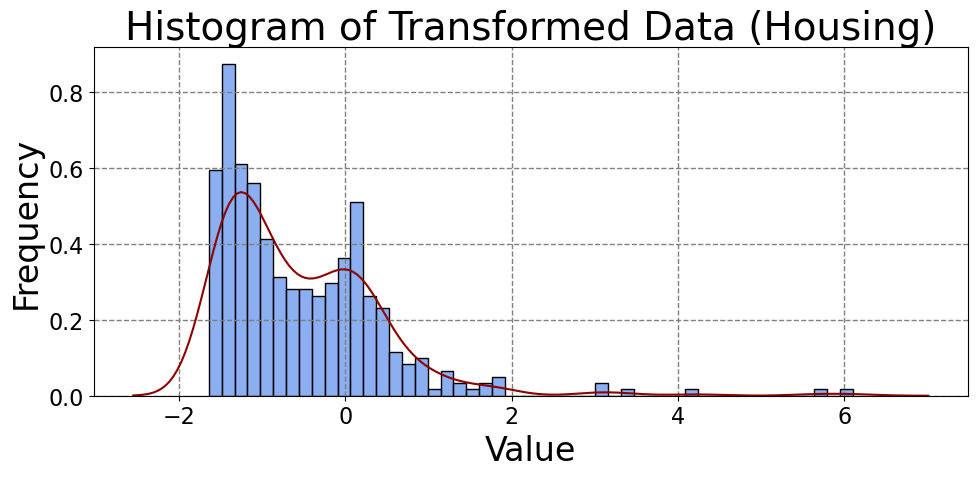

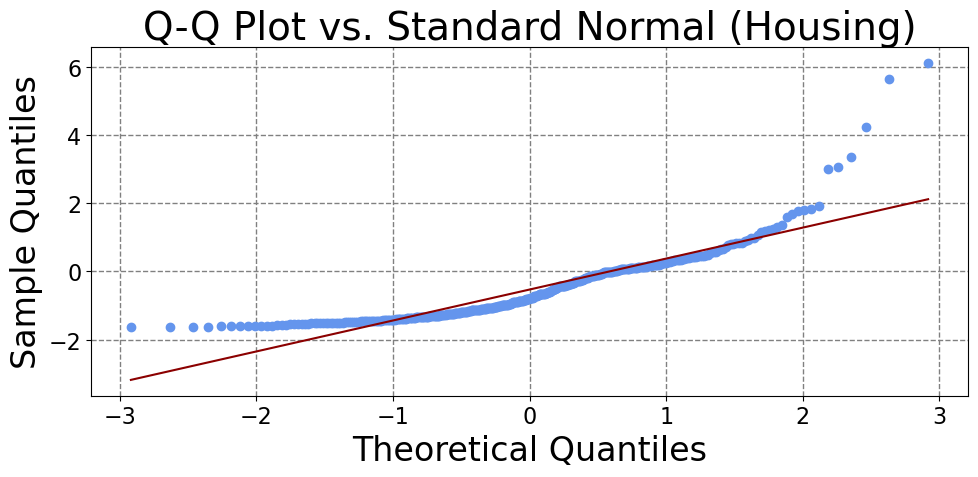

  KS-test: statistic=0.5804, p-value=0.0000
  (p <= 0.05: The null hypothesis is rejected; data may not be normal)


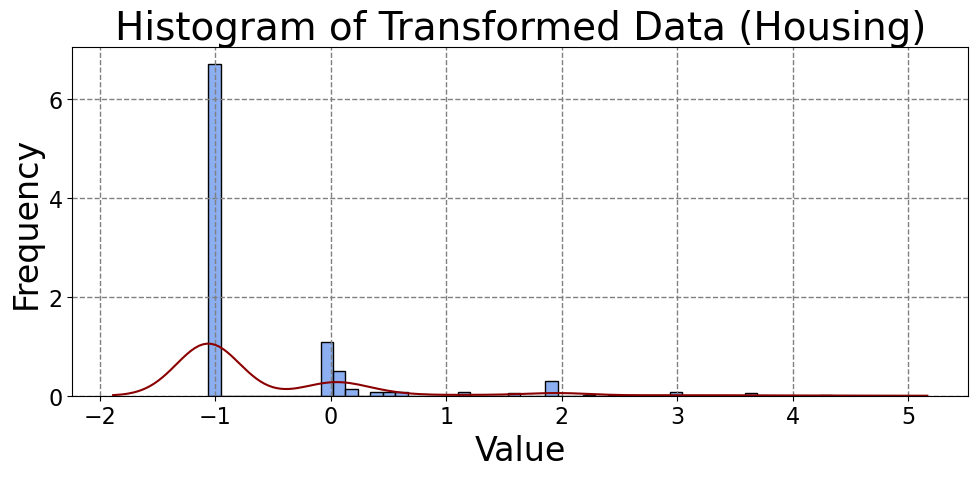

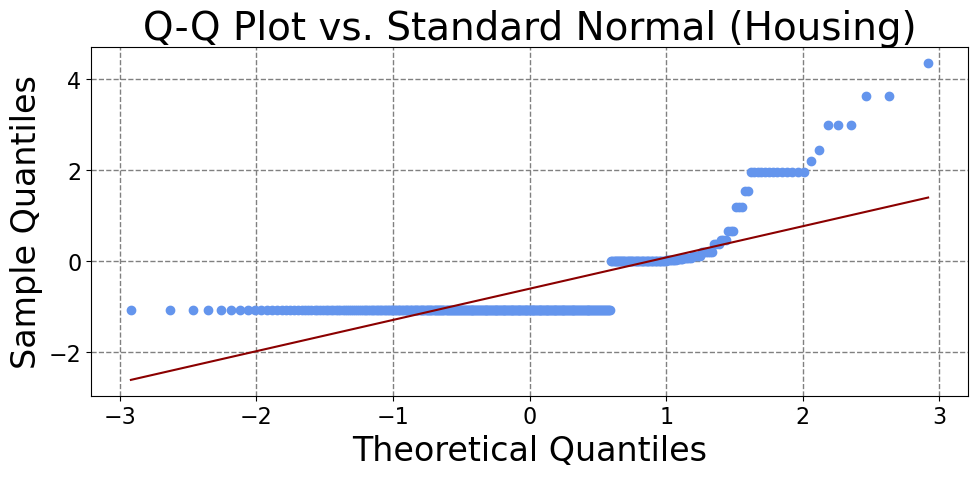

  KS-test: statistic=0.1482, p-value=0.0000
  (p <= 0.05: The null hypothesis is rejected; data may not be normal)


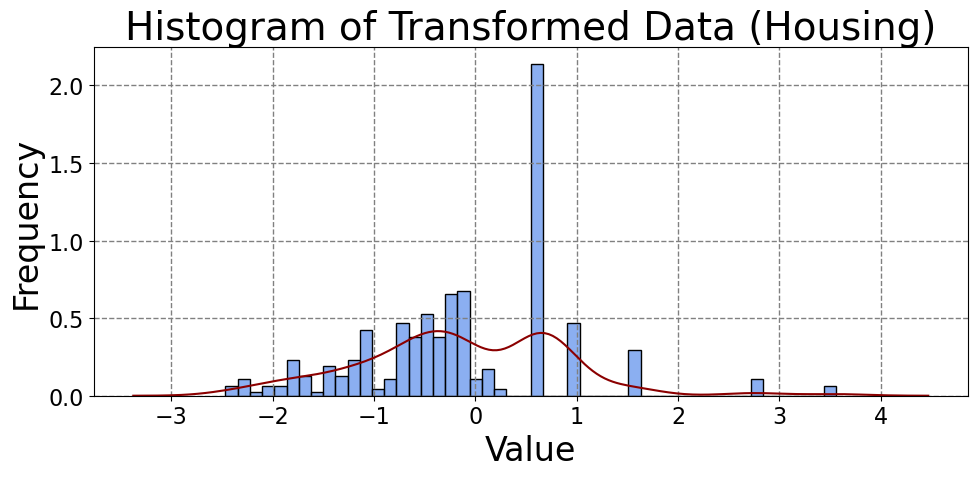

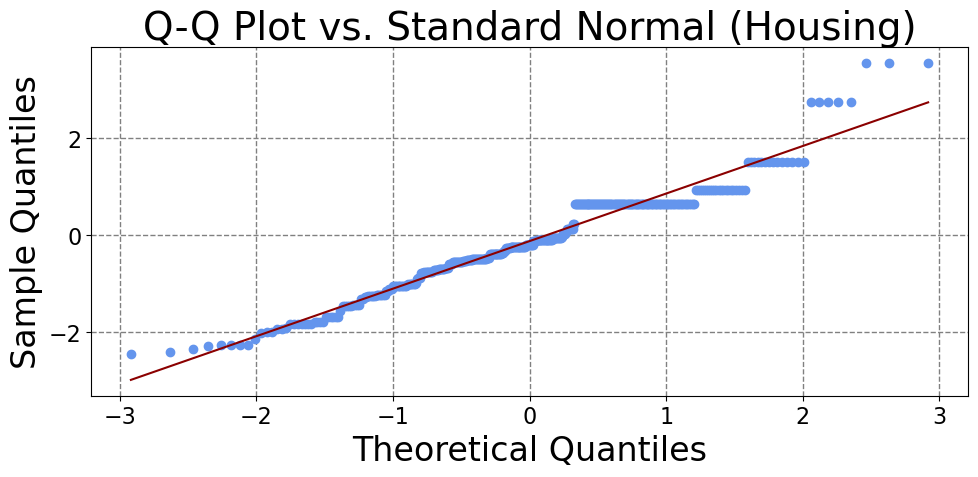

  KS-test: statistic=0.7061, p-value=0.0000
  (p <= 0.05: The null hypothesis is rejected; data may not be normal)


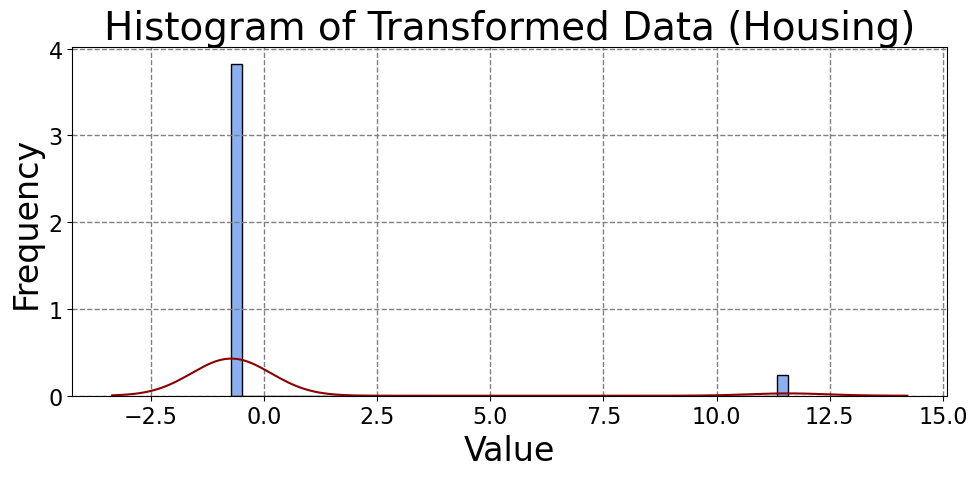

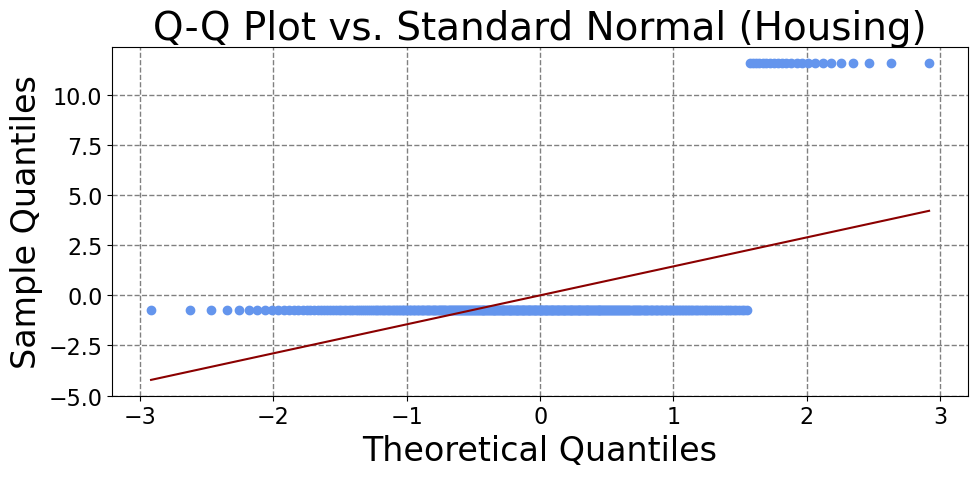

  KS-test: statistic=0.0661, p-value=0.0620
  (p > 0.05: The null hypothesis that the data is normally distributed cannot be rejected)


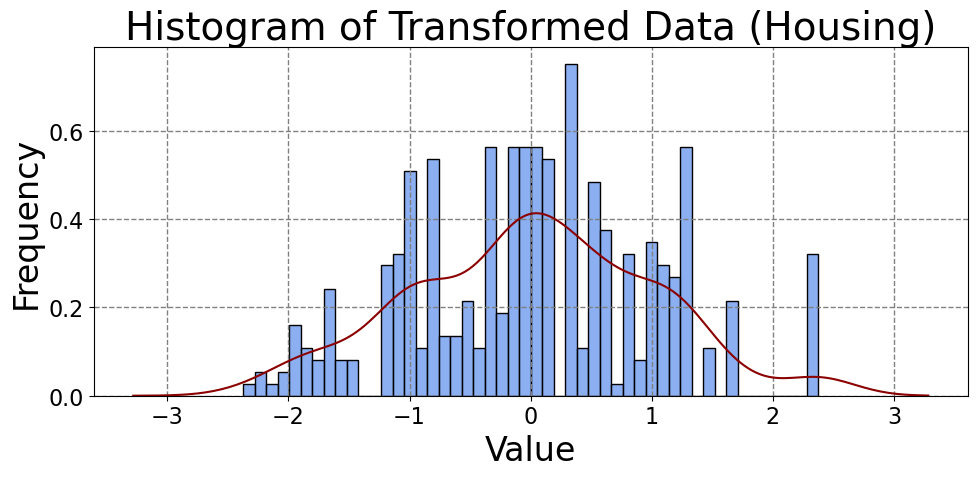

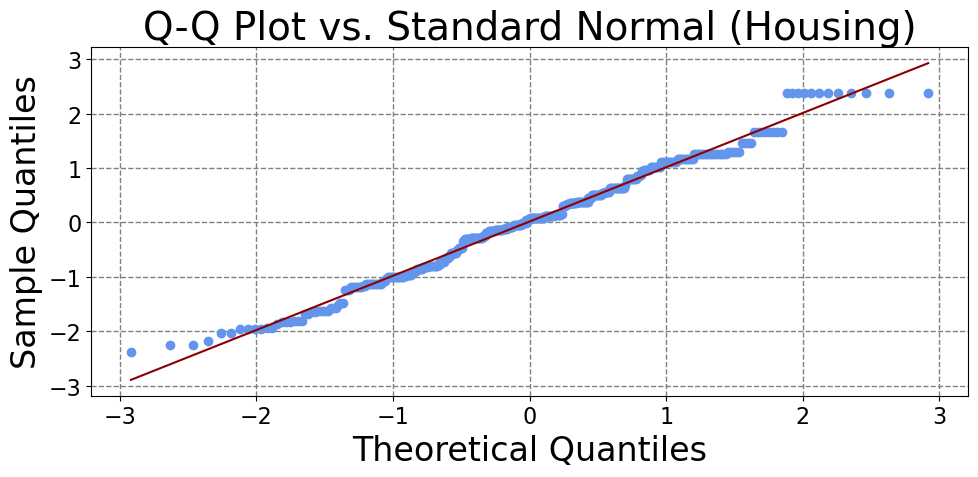

  KS-test: statistic=0.0345, p-value=0.7273
  (p > 0.05: The null hypothesis that the data is normally distributed cannot be rejected)


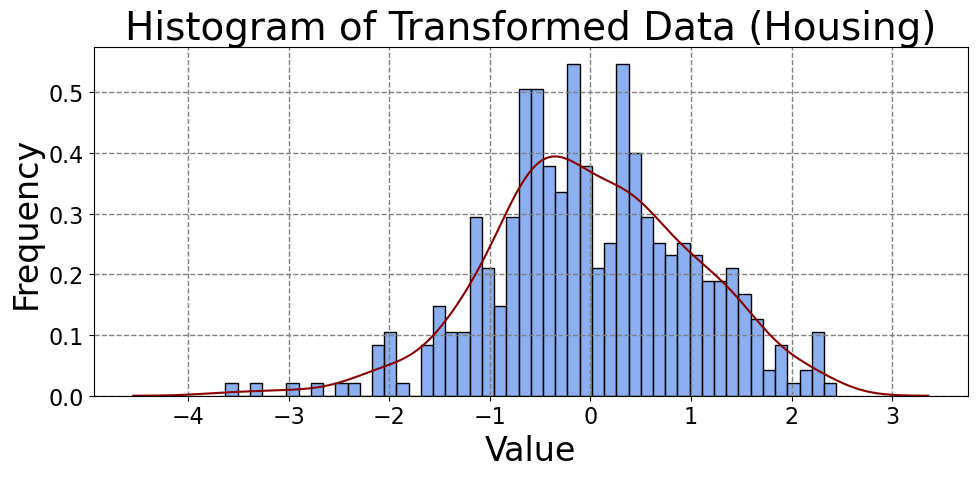

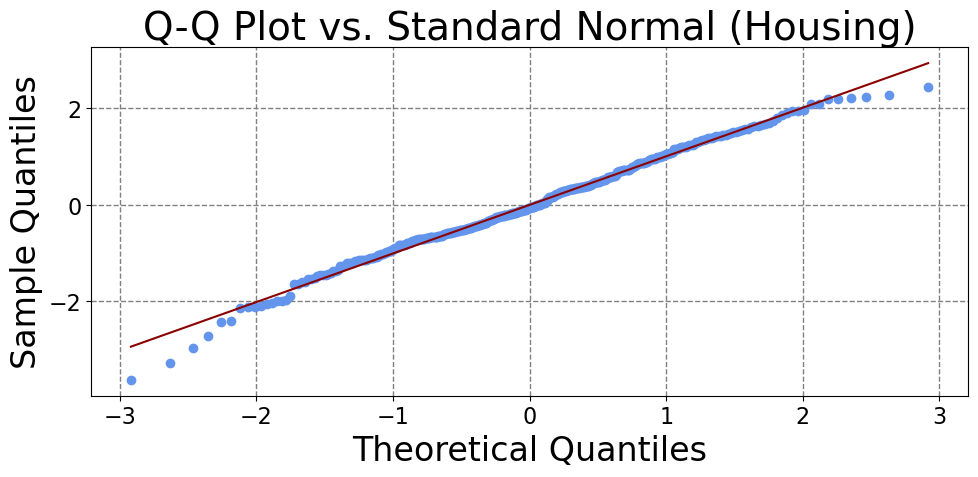

  KS-test: statistic=0.0564, p-value=0.1590
  (p > 0.05: The null hypothesis that the data is normally distributed cannot be rejected)


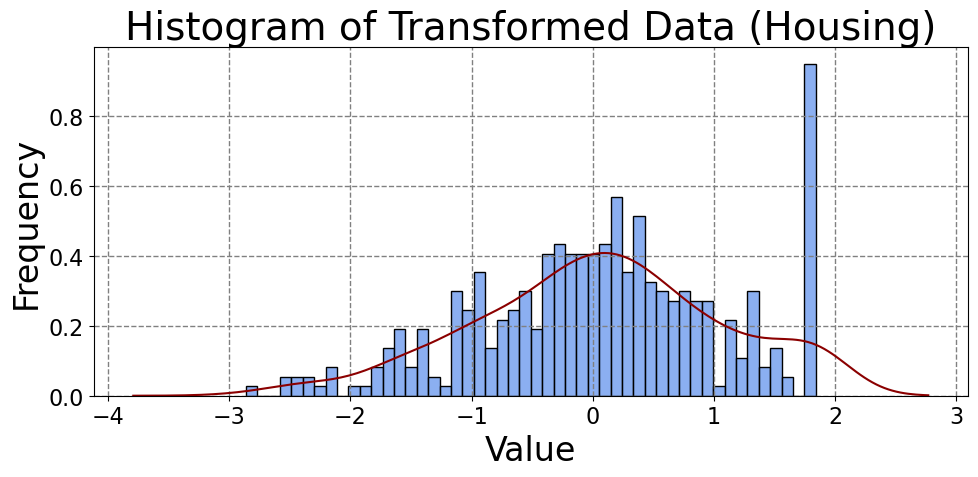

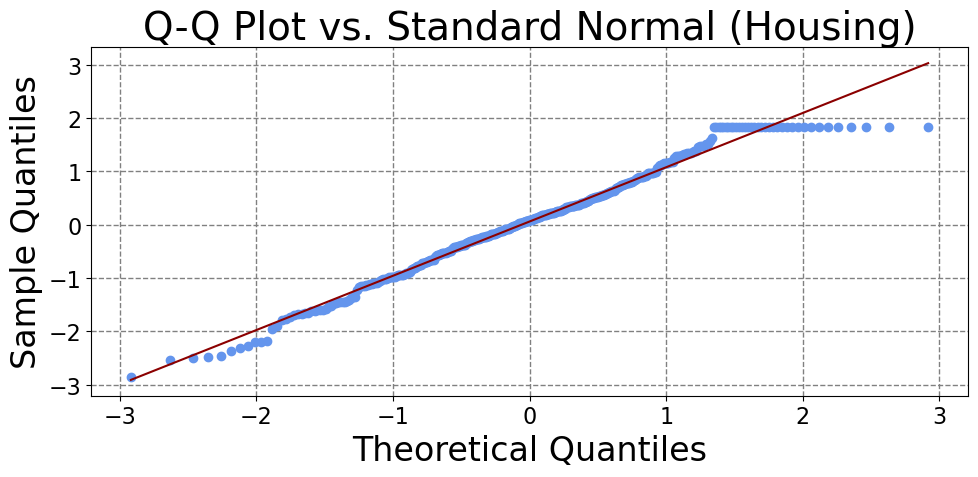

  KS-test: statistic=0.0279, p-value=0.9125
  (p > 0.05: The null hypothesis that the data is normally distributed cannot be rejected)


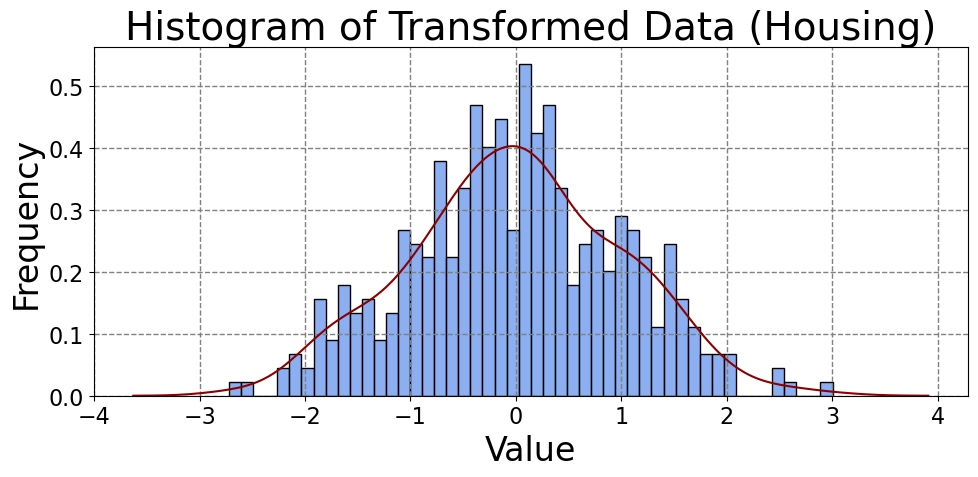

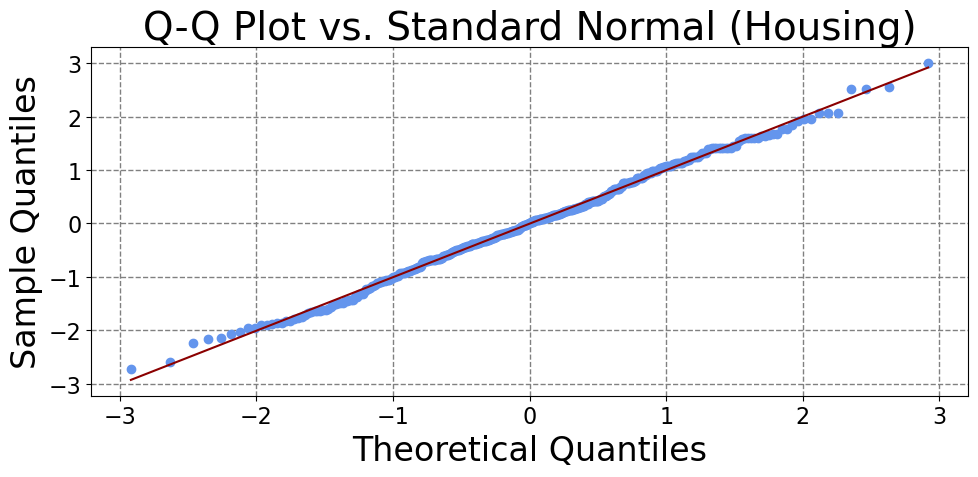

  KS-test: statistic=0.2709, p-value=0.0000
  (p <= 0.05: The null hypothesis is rejected; data may not be normal)


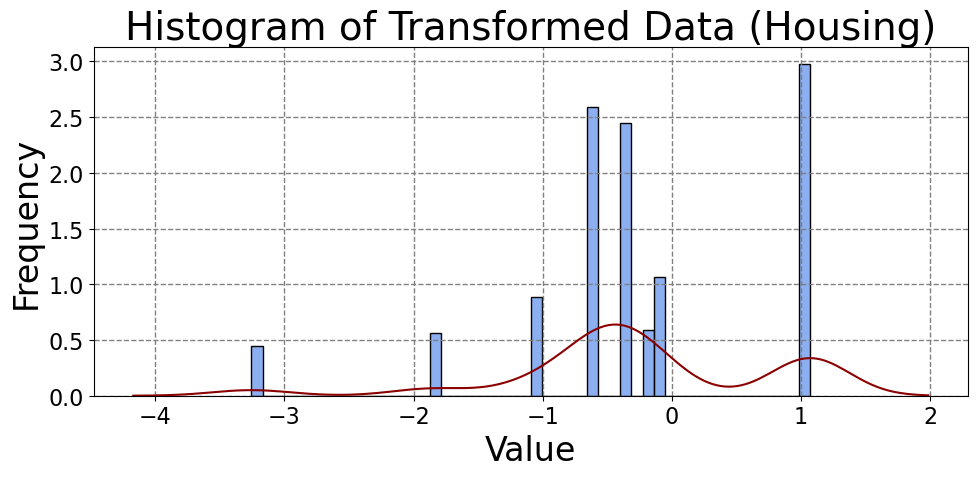

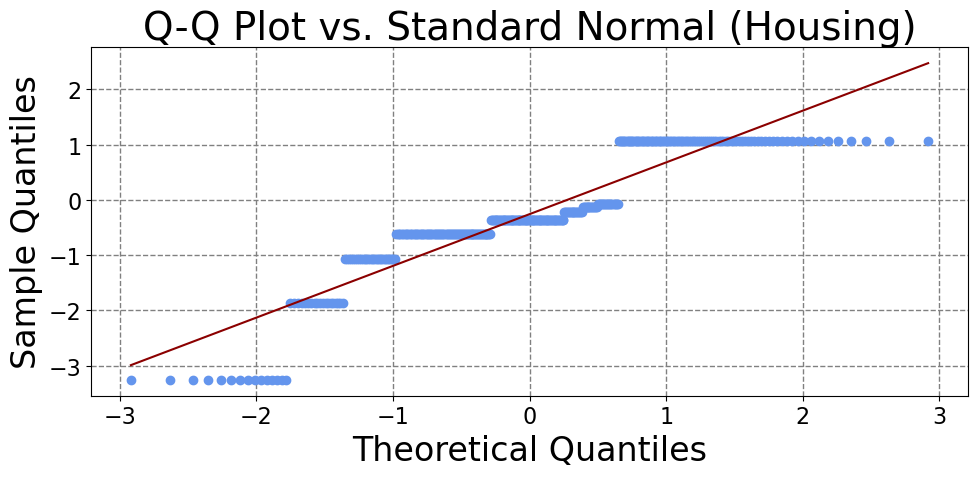

  KS-test: statistic=0.2652, p-value=0.0000
  (p <= 0.05: The null hypothesis is rejected; data may not be normal)


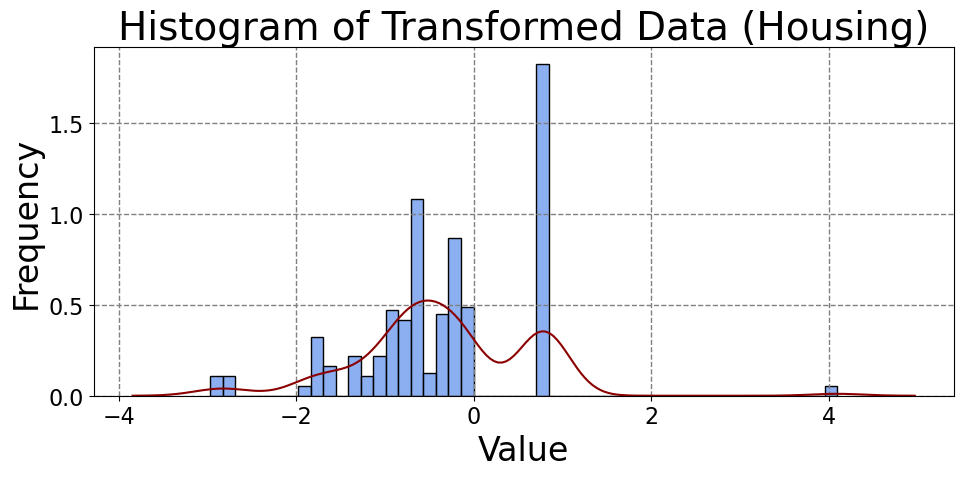

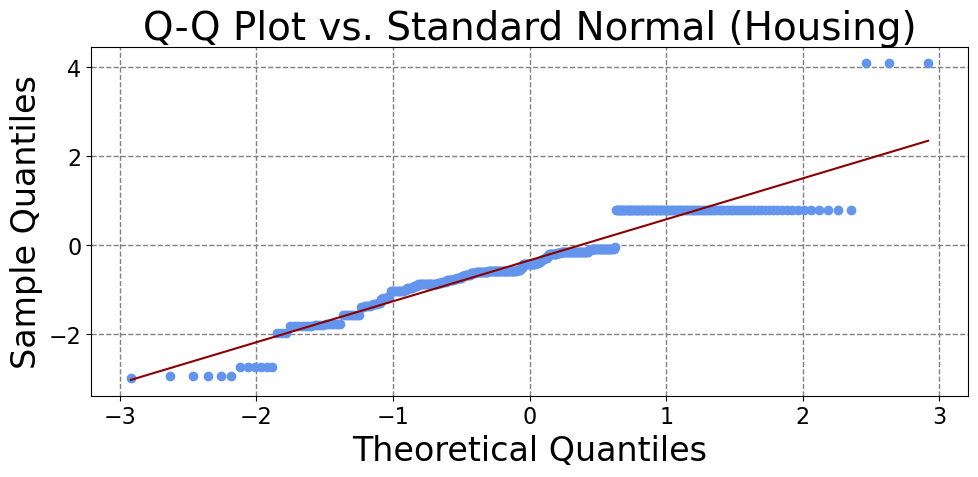

  KS-test: statistic=0.1627, p-value=0.0000
  (p <= 0.05: The null hypothesis is rejected; data may not be normal)


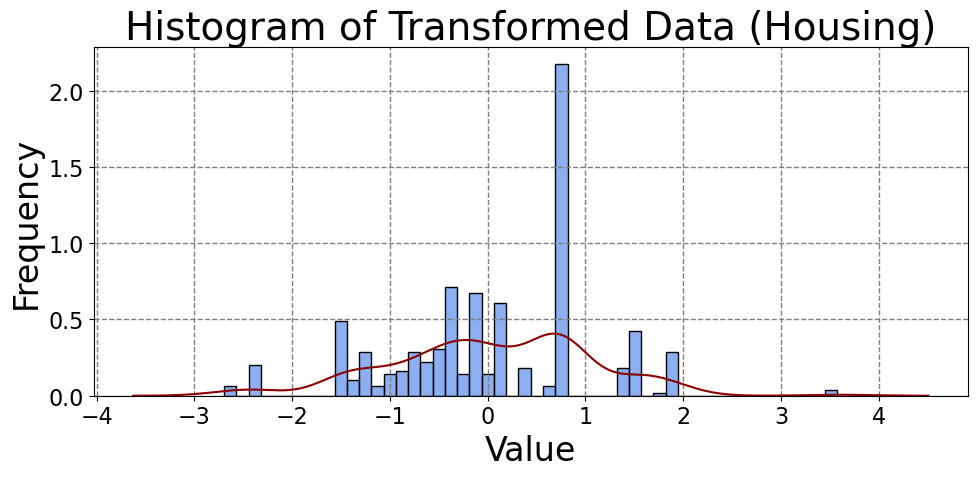

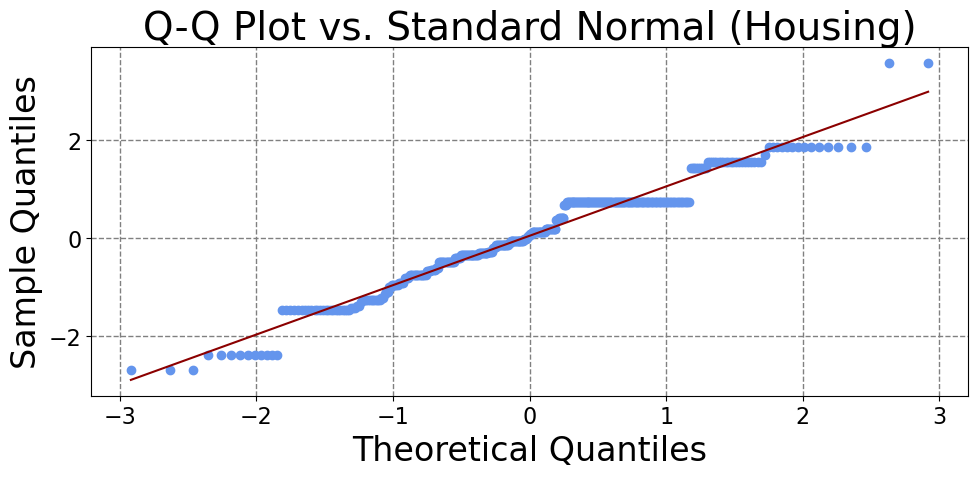

  KS-test: statistic=0.2607, p-value=0.0000
  (p <= 0.05: The null hypothesis is rejected; data may not be normal)


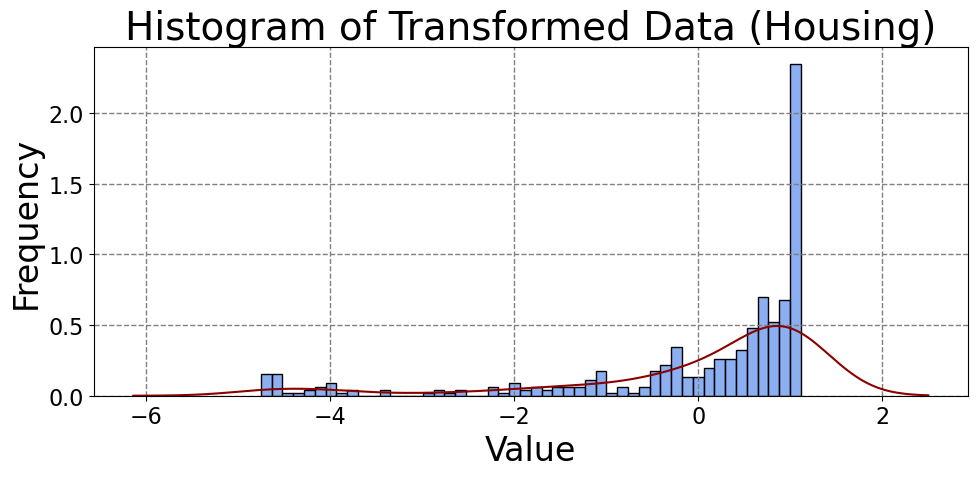

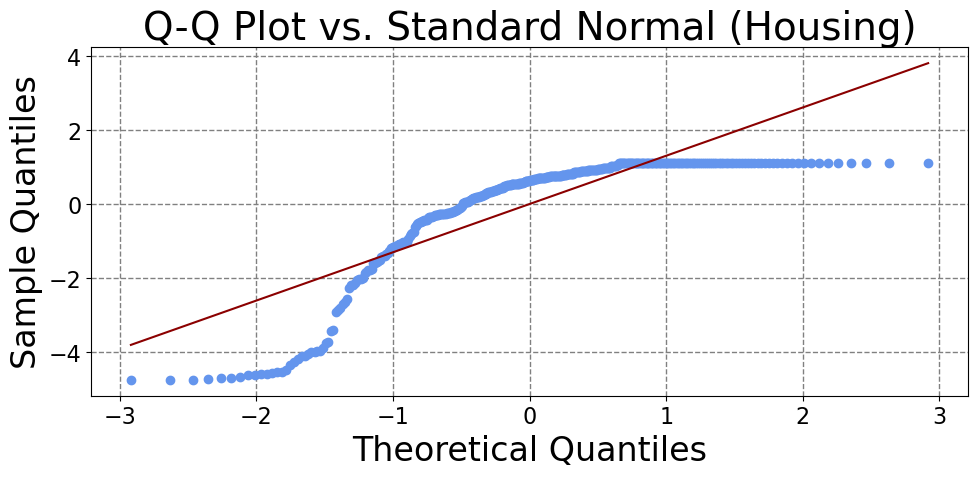

  KS-test: statistic=0.0291, p-value=0.8844
  (p > 0.05: The null hypothesis that the data is normally distributed cannot be rejected)


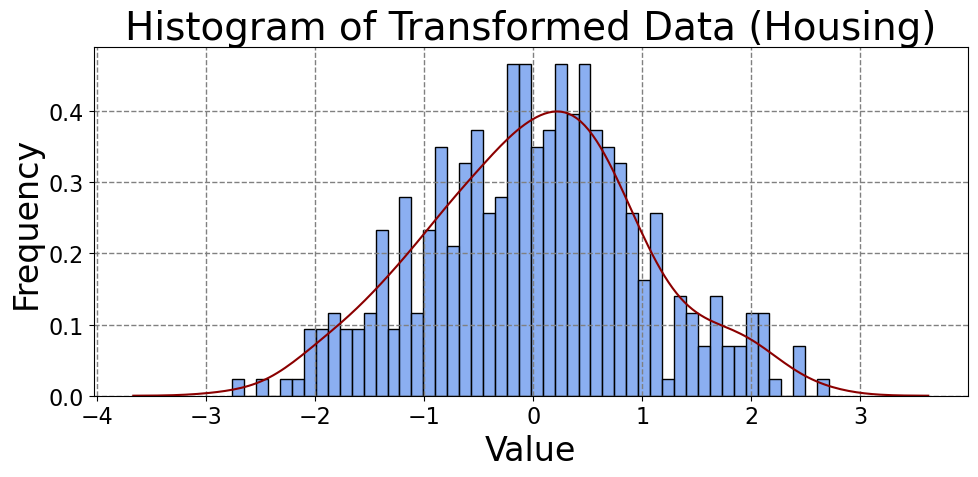

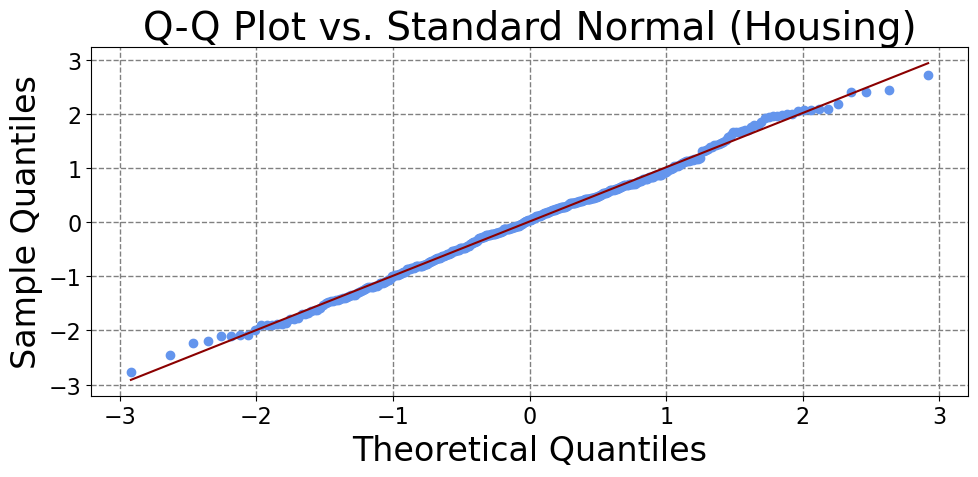

In [8]:
all_folds_data = boston_housing_data()

for i, fold_data in enumerate(all_folds_data):
    print(f"--------------------- FOLD {i} -----------------------")
    X_train, X_test, y_train, y_test, y_mean, y_std = fold_data

    X_transformed, X_test_transformed = nf_data(X_train, X_test)
    break

--------------------- FOLD 0 -----------------------
  KS-test: statistic=0.0414, p-value=0.1155
  (p > 0.05: The null hypothesis that the data is normally distributed cannot be rejected)


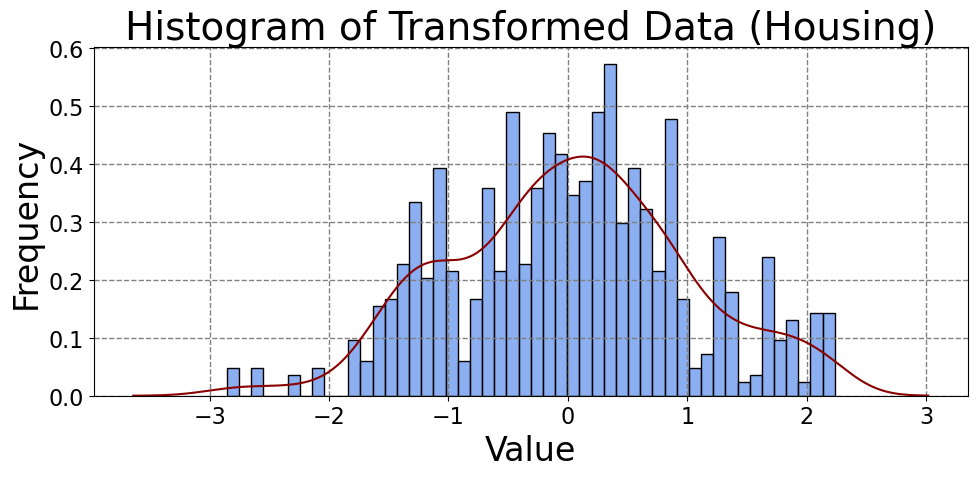

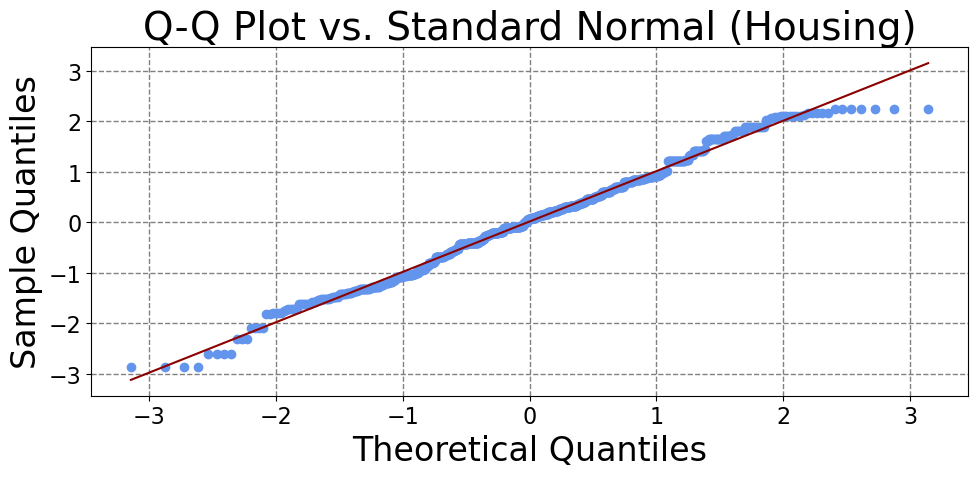

  KS-test: statistic=0.3269, p-value=0.0000
  (p <= 0.05: The null hypothesis is rejected; data may not be normal)


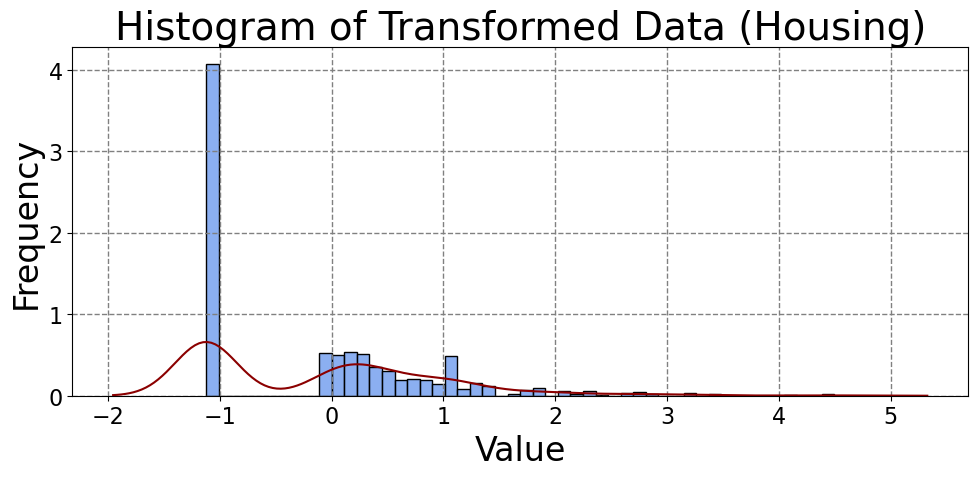

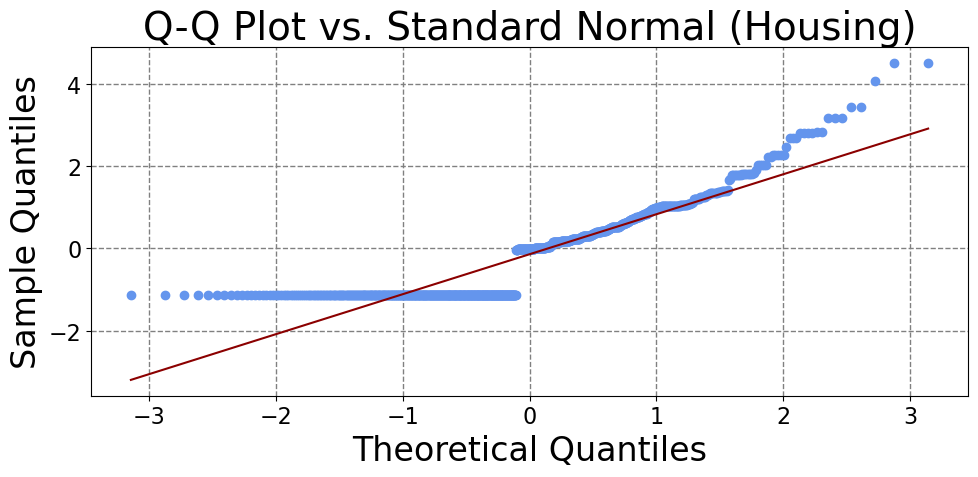

  KS-test: statistic=0.4122, p-value=0.0000
  (p <= 0.05: The null hypothesis is rejected; data may not be normal)


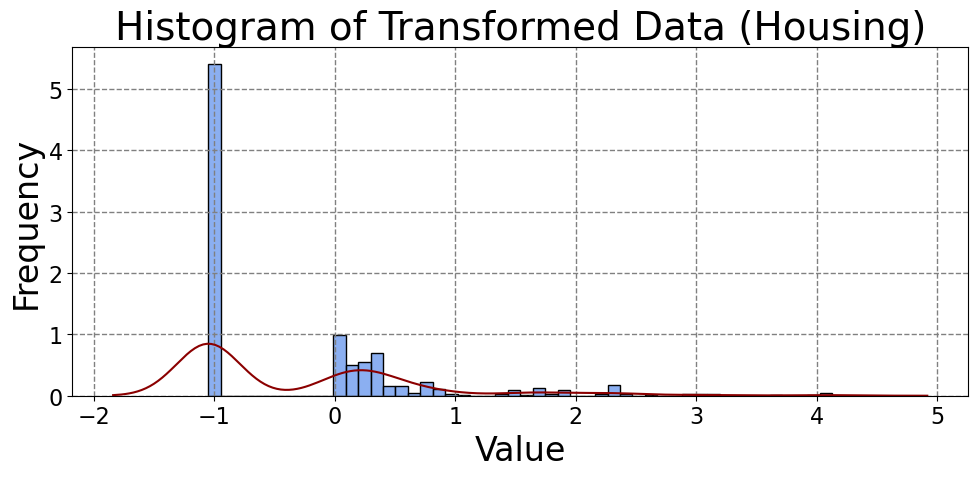

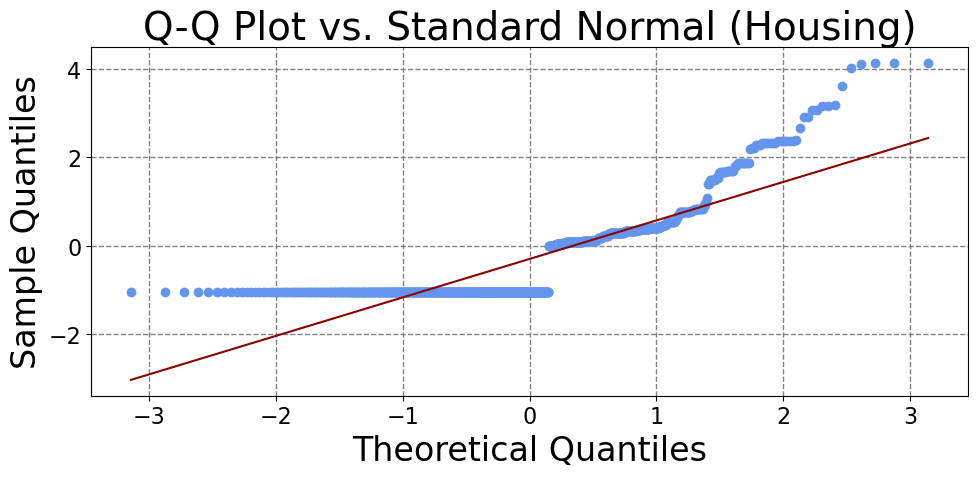

  KS-test: statistic=0.0726, p-value=0.0003
  (p <= 0.05: The null hypothesis is rejected; data may not be normal)


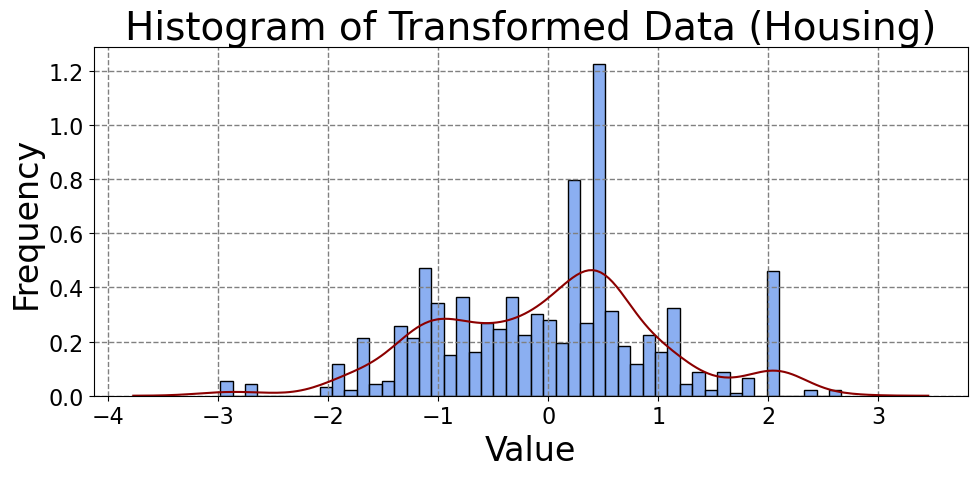

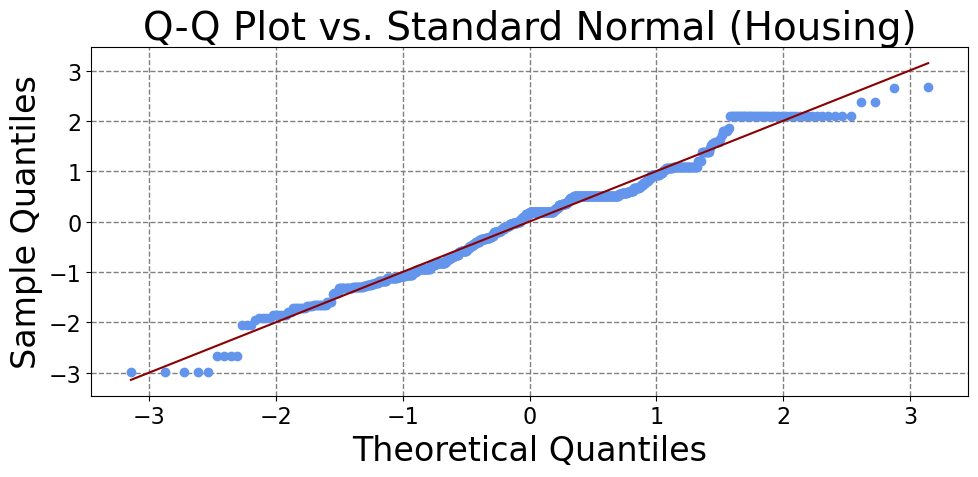

  KS-test: statistic=0.2389, p-value=0.0000
  (p <= 0.05: The null hypothesis is rejected; data may not be normal)


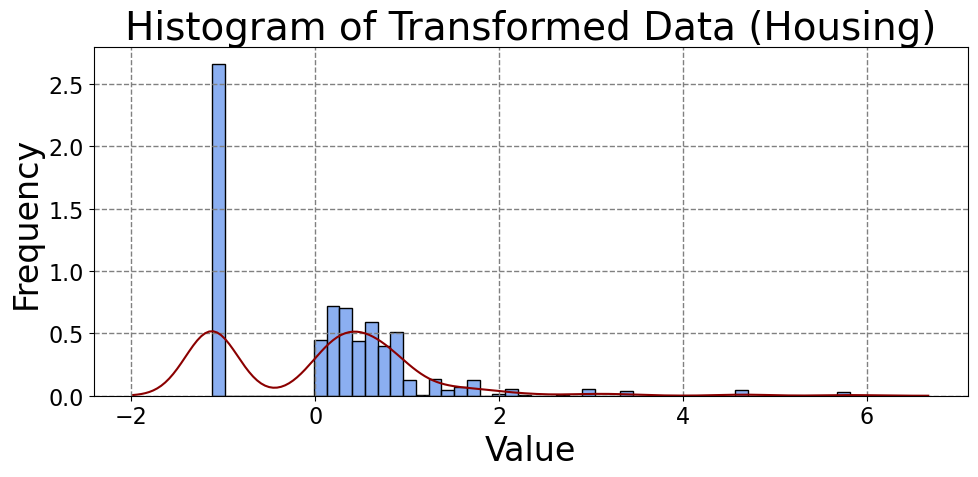

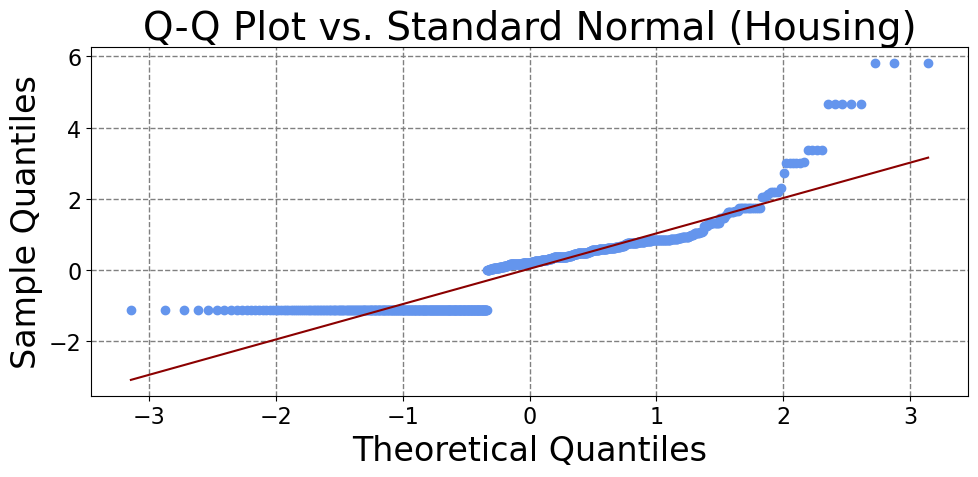

  KS-test: statistic=0.0782, p-value=0.0001
  (p <= 0.05: The null hypothesis is rejected; data may not be normal)


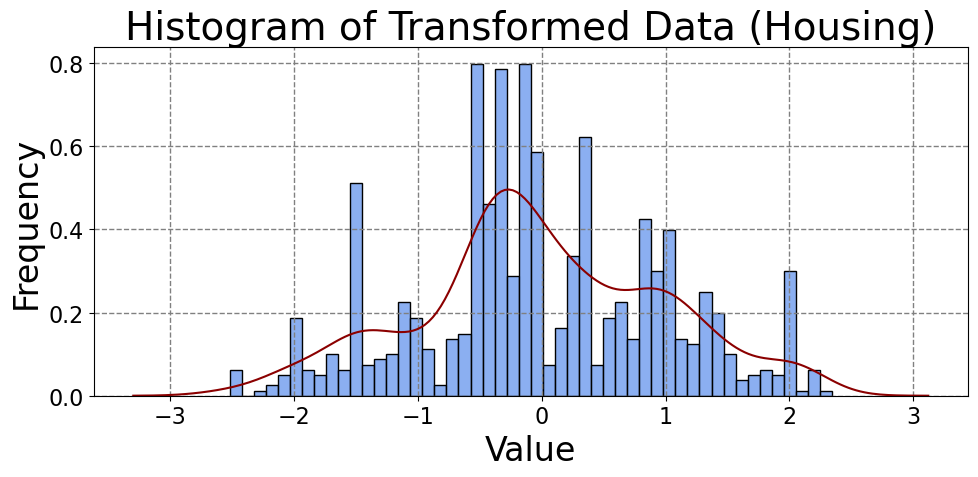

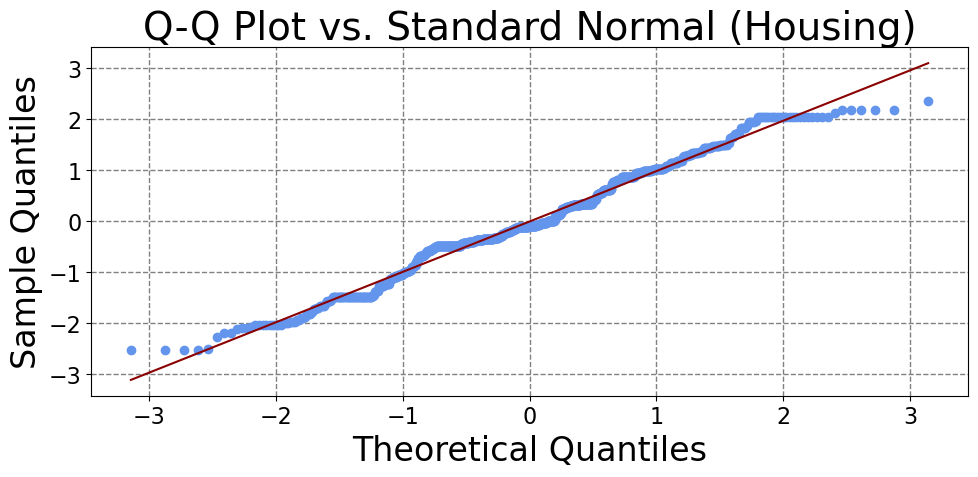

  KS-test: statistic=0.0768, p-value=0.0001
  (p <= 0.05: The null hypothesis is rejected; data may not be normal)


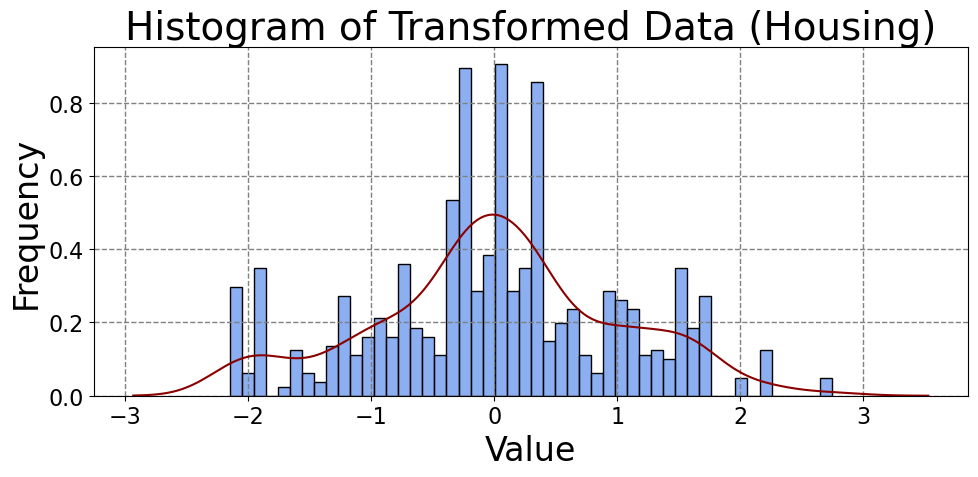

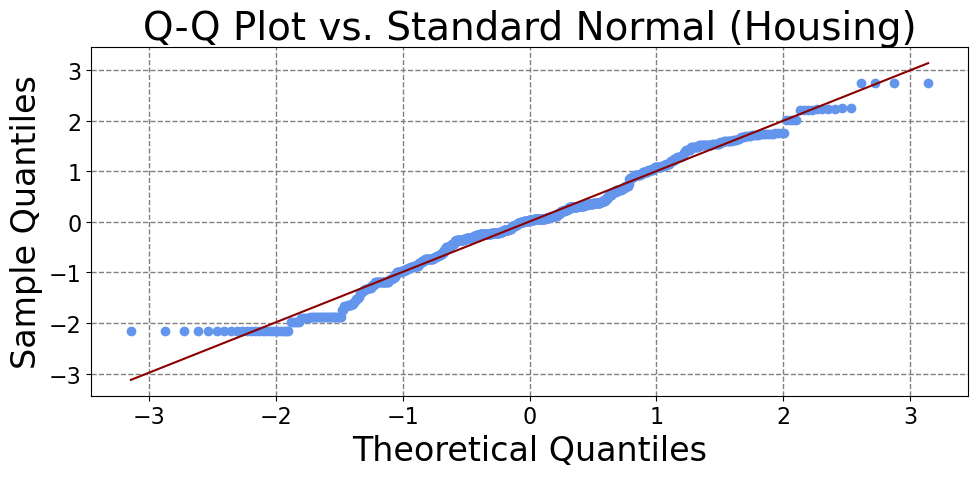

  KS-test: statistic=0.2622, p-value=0.0000
  (p <= 0.05: The null hypothesis is rejected; data may not be normal)


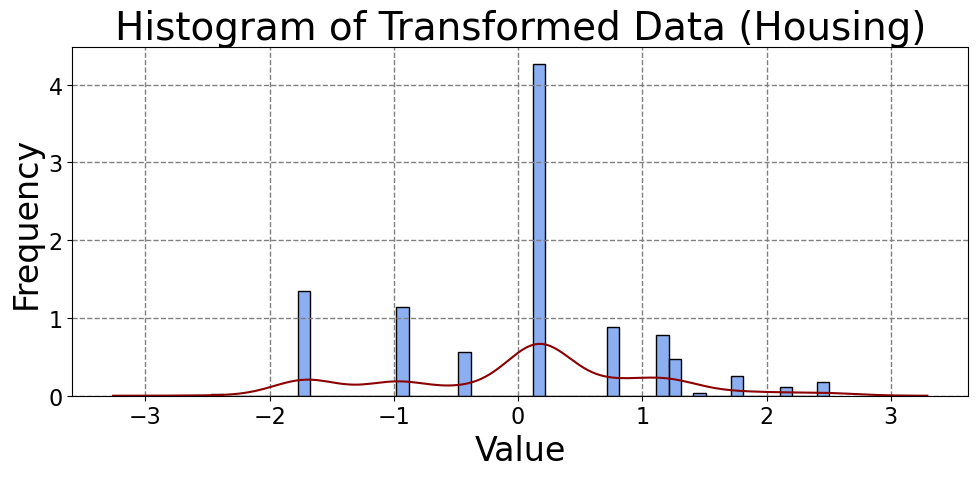

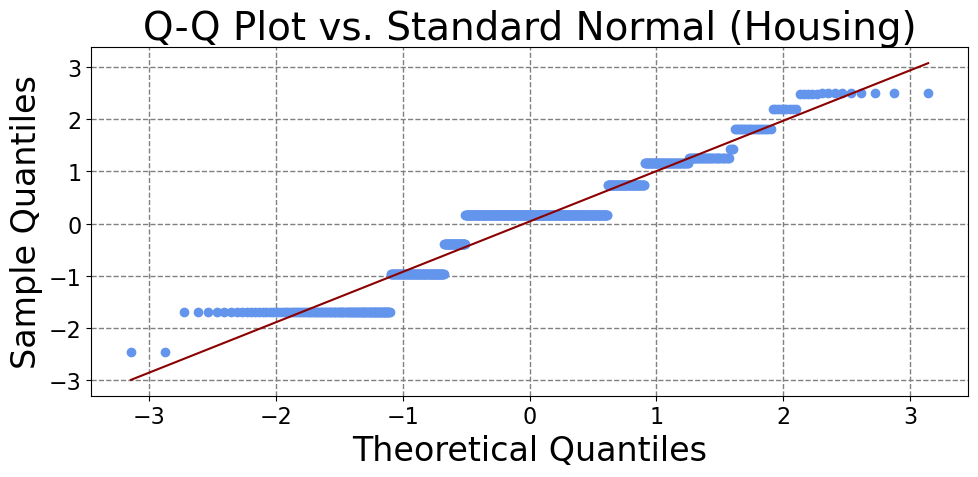

In [9]:
all_folds_data = concrete_data()

for i, fold_data in enumerate(all_folds_data):
    print(f"--------------------- FOLD {i} -----------------------")
    X_train, X_test, y_train, y_test, y_mean, y_std = fold_data

    X_transformed, X_test_transformed = nf_data(X_train, X_test)
    break